In [1]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
from dropout import ResNet_dropout, BasicBlock

ImportError: cannot import name 'ResNet_dropout' from 'dropout' (C:\Users\User\DSC180B-Capstone-Network-Dissection\dropout.py)

In [5]:
model = ResNet_dropout(img_channels = 3, num_layers = 18, block = BasicBlock, num_classes = 10)

NameError: name 'ResNet' is not defined

In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (drop): Dropout(p=0.2, inplace=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (drop): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, mome

In [1]:
from focuseddropout import FocusedDropout

In [2]:
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 1, downsample: nn.Module = None, dropout_rate: float = 0.2) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.drop = FocusedDropout(par_rate = 0.1)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
        
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        out = self.drop(out)
        return  out
    
class ResNet(nn.Module):
    def __init__(self, img_channels: int, num_layers: int, block: Type[BasicBlock], num_classes: int  = 1000, dropout_rate: float = 0.2) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.drop = FocusedDropout(par_rate = 0.1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
        
        
    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [7]:
from getdata import get_data
from train import train, validate
import torch.optim as optim

In [4]:
model = ResNet(img_channels = 3, num_layers = 18, block = BasicBlock, num_classes = 10)

In [5]:
train_loader, valid_loader = get_data()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

In [9]:
for _ in range(10):
    train_loss, train_acc = train(model, train_loader, optimizer, loss, 'cpu')
    print(f"Training loss: {train_loss}, Training accuracy: {train_acc}")
print("Training Done!")

val_loss, val_acc = validate(model, valid_loader, loss, 'cpu')
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

  0%|          | 0/782 [00:00<?, ?it/s]

Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 1.5502623607740378, Training accuracy: 43.802
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 1.2155319936287678, Training accuracy: 55.891999999999996
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 1.0459514766397988, Training accuracy: 62.053999999999995
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 0.9080180337514414, Training accuracy: 67.23400000000001
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 0.7909041500609854, Training accuracy: 71.202
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 0.6864065388813043, Training accuracy: 75.156
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 0.5920293400507144, Training accuracy: 78.506
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 0.5223934475113364, Training accuracy: 80.81
Training


  0%|          | 0/782 [00:00<?, ?it/s]

Training loss: 0.4581886837092202, Training accuracy: 83.138
Training


  1%|          | 1/157 [00:00<00:20,  7.59it/s]

Training loss: 0.41912284794518406, Training accuracy: 84.5
Training Done!
Validation


100%|██████████| 157/157 [00:18<00:00,  8.28it/s]

Validation loss: 1.3282888858181656, Validation accuracy: 62.93


In [11]:
import pickle
filename = "models/resnet18_cifar10_focuseddropout0.1adam"
pickle.dump(model, open(filename, "wb"))
print(f"Model saved on {filename}")

Model saved on models/resnet18_cifar10_focuseddropout0.1adam


In [1]:
import matplotlib.pyplot as plt

In [10]:
x = range(1,10)
y1 = range(10,100,10)
y2 = range(100,10,-10)

In [32]:
model = "resnet18_cifar10_focuseddropout0.1adam"

In [48]:
def plot(train_loss, train_acc, val_loss, val_acc):
    x = range(1, 1+len(train_loss))
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle(f'Model: {model}')
    ax1.plot(x, train_loss, label = "Training loss")
    ax1.plot(x, val_loss, label = "Test loss")

    ax1.set_title("Training & Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(x, train_acc, label = "Training acc")
    ax2.plot(x, val_acc, label = "Test acc")
    ax2.set_title("Training & Validation Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    
    ax1.legend()
    ax2.legend()

    fig.tight_layout(pad = 0.5)
    plt.savefig(f"plots/{model}.png")
    plt.show()

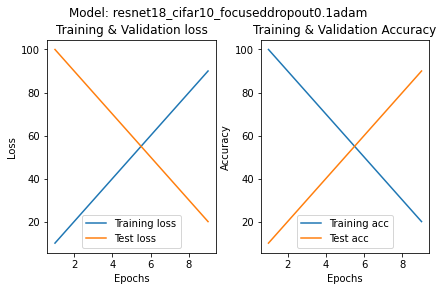

In [50]:
plot(y1,y2,y2,y1)

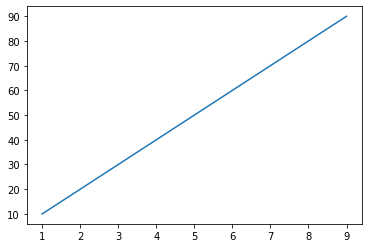

In [2]:
plt.subplots(range(1,10), range(10,100, 10))

In [37]:
import torch
torch.cuda.is_available()

False

In [35]:
'Cuda:0'

'Cuda:0'

In [45]:
torch.load("test_data.pt")[0][0].to('cuda')

AssertionError: Torch not compiled with CUDA enabled